# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [16]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

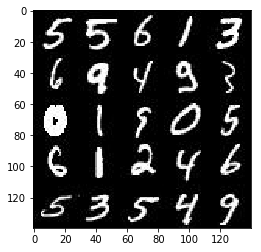

In [17]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

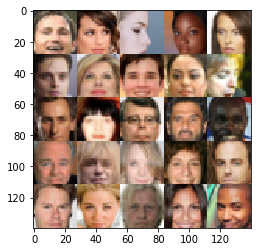

In [18]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [19]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.1
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [20]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    real_dim = (image_width, image_height, image_channels)
    inputs_real = tf.placeholder(tf.float32, (None, *real_dim), name='input_real')
    inputs_z = tf.placeholder(tf.float32, (None, z_dim), name='input_z')
    learning_rate = tf.placeholder(tf.float32, shape=(), name='learning_rate')

    return inputs_real, inputs_z, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the generator, tensor logits of the generator).

In [29]:
def discriminator(images, reuse=False, alpha=0.2):
    """
    Create the discriminator network
    :param image: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    with tf.variable_scope('discriminator', reuse=reuse):
        
        k_init = tf.random_normal_initializer(mean=0.0, stddev=0.02)
        
        # Input layer is 28x28x3
        x1 = tf.layers.conv2d(images, 64, 5, strides=2, padding='same', kernel_initializer=k_init)
        relu1 = tf.maximum(alpha * x1, x1)
        # 14x14x64
        
        x2 = tf.layers.conv2d(relu1, 128, 5, strides=1, padding='same', kernel_initializer=k_init)
        bn2 = tf.layers.batch_normalization(x2, training=True)
        relu2 = tf.maximum(alpha * bn2, bn2)
        # 14x14x128
        
        x3 = tf.layers.conv2d(relu2, 256, 5, strides=2, padding='same', kernel_initializer=k_init)
        bn3 = tf.layers.batch_normalization(x3, training=True)
        relu3 = tf.maximum(alpha * bn3, bn3)
        # 7x7x256

        # Flatten
        flat = tf.reshape(relu3, (-1, 7*7*256))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)


    return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [22]:
def generator(z, out_channel_dim, is_train=True, alpha=0.2):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    
    with tf.variable_scope('generator', reuse=not is_train):
        # First fully connected layer
        x1 = tf.layers.dense(z, 7*7*256)
        # Reshape it to start the convolutional stack
        x1 = tf.reshape(x1, (-1, 7, 7, 256))
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = tf.maximum(alpha * x1, x1)
        # 7x7x256
        
        x2 = tf.layers.conv2d_transpose(x1, 128, 5, strides=1, padding='same')
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.maximum(alpha * x2, x2)
        # 7x7x128
        
        x3 = tf.layers.conv2d_transpose(x2, 64, 5, strides=2, padding='same')
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        x3 = tf.maximum(alpha * x3, x3)
        # 14x14x64
        
        
        # Output layer
        logits = tf.layers.conv2d_transpose(x3, out_channel_dim, 5, strides=2, padding='same')
        # 28x28xout_channel_dim
        
        out = tf.tanh(logits)

    
        return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


In [50]:
def model_loss(input_real, input_z, out_channel_dim, alpha=0.2):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    g_model = generator(input_z, out_channel_dim, alpha=alpha)
    d_model_real, d_logits_real = discriminator(input_real, alpha=alpha)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True, alpha=alpha)

    smooth = 0.1
    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)*(1-smooth)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake

    return d_loss, g_loss

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [49]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

        # Optimize
    d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)

    update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
    g_updates = [opt for opt in update_ops if opt.name.startswith('generator')]
    with tf.control_dependencies(g_updates):
       g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1).minimize(g_loss, var_list=g_vars)
    
    
    return d_train_opt, g_train_opt

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [37]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [51]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    
    #build model
        
    _, image_width, image_height, image_channels = data_shape
    
    
    input_real, input_z, learn_rate = model_inputs(image_width,image_height,image_channels, z_dim)
    
    d_loss, g_loss = model_loss(input_real, input_z, image_channels, alpha=0.2)
        
    d_opt, g_opt = model_opt(d_loss, g_loss, learning_rate, beta1)
    
    #train model
    print_every = 10
    show_every = 100
    samples, losses = [], []
    
    with tf.Session() as sess:
        steps = 0
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                #get image data, ignore labels, resize to -1.0 to 1.0
                
                batch_images *= 2.0
                
                steps += 1
                
                #random noise as input to the discriminator
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                
                # Run optimizers
                _ = sess.run(d_opt, feed_dict={input_real: batch_images, input_z: batch_z})
                _ = sess.run(g_opt, feed_dict={input_z: batch_z})

                if steps % print_every == 0:
                    # At the end of each epoch, get the losses and print them out
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z})

                    print("Epoch {}/{}...".format(epoch_i+1, epochs),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                    # Save losses to view after training
                    losses.append((train_loss_d, train_loss_g))

                if steps % show_every == 0:
                    show_generator_output(sess, 25, input_z, image_channels, data_image_mode)
    
    return losses, samples                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 0.6378... Generator Loss: 1.6106
Epoch 1/2... Discriminator Loss: 0.6171... Generator Loss: 1.9199
Epoch 1/2... Discriminator Loss: 0.8488... Generator Loss: 2.5064
Epoch 1/2... Discriminator Loss: 1.6604... Generator Loss: 4.1276
Epoch 1/2... Discriminator Loss: 1.3103... Generator Loss: 4.0307
Epoch 1/2... Discriminator Loss: 0.6016... Generator Loss: 2.8506
Epoch 1/2... Discriminator Loss: 0.5835... Generator Loss: 1.9606
Epoch 1/2... Discriminator Loss: 0.7211... Generator Loss: 2.0774
Epoch 1/2... Discriminator Loss: 0.7354... Generator Loss: 1.9536
Epoch 1/2... Discriminator Loss: 0.7369... Generator Loss: 2.6392


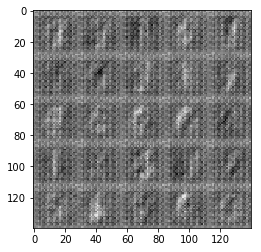

Epoch 1/2... Discriminator Loss: 1.5052... Generator Loss: 4.1300
Epoch 1/2... Discriminator Loss: 1.1819... Generator Loss: 3.4479
Epoch 1/2... Discriminator Loss: 1.0931... Generator Loss: 3.0437
Epoch 1/2... Discriminator Loss: 0.8770... Generator Loss: 2.8838
Epoch 1/2... Discriminator Loss: 0.9148... Generator Loss: 2.8222
Epoch 1/2... Discriminator Loss: 0.8866... Generator Loss: 2.7626
Epoch 1/2... Discriminator Loss: 0.8765... Generator Loss: 2.7948
Epoch 1/2... Discriminator Loss: 0.9616... Generator Loss: 3.0311
Epoch 1/2... Discriminator Loss: 0.7235... Generator Loss: 2.4020
Epoch 1/2... Discriminator Loss: 0.8078... Generator Loss: 2.4725


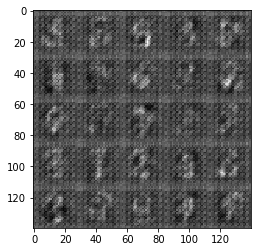

Epoch 1/2... Discriminator Loss: 0.8908... Generator Loss: 2.8932
Epoch 1/2... Discriminator Loss: 0.7963... Generator Loss: 2.6907
Epoch 1/2... Discriminator Loss: 0.9138... Generator Loss: 3.0319
Epoch 1/2... Discriminator Loss: 0.8085... Generator Loss: 2.7195
Epoch 1/2... Discriminator Loss: 0.6568... Generator Loss: 2.4063
Epoch 1/2... Discriminator Loss: 0.8138... Generator Loss: 2.7537
Epoch 1/2... Discriminator Loss: 0.8755... Generator Loss: 2.9937
Epoch 1/2... Discriminator Loss: 0.6762... Generator Loss: 2.4477
Epoch 1/2... Discriminator Loss: 0.7226... Generator Loss: 2.6864
Epoch 1/2... Discriminator Loss: 0.7844... Generator Loss: 2.8356


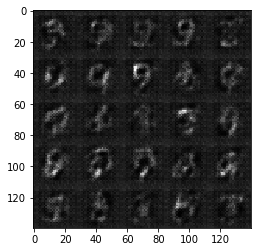

Epoch 1/2... Discriminator Loss: 0.6982... Generator Loss: 2.3969
Epoch 1/2... Discriminator Loss: 0.7051... Generator Loss: 2.4616
Epoch 1/2... Discriminator Loss: 0.8075... Generator Loss: 2.8241
Epoch 1/2... Discriminator Loss: 0.7251... Generator Loss: 2.6989
Epoch 1/2... Discriminator Loss: 0.6992... Generator Loss: 2.5809
Epoch 1/2... Discriminator Loss: 0.6272... Generator Loss: 1.5543
Epoch 1/2... Discriminator Loss: 1.0467... Generator Loss: 0.7478
Epoch 1/2... Discriminator Loss: 0.6563... Generator Loss: 1.4822
Epoch 1/2... Discriminator Loss: 0.9552... Generator Loss: 0.8628
Epoch 1/2... Discriminator Loss: 0.8239... Generator Loss: 1.0703


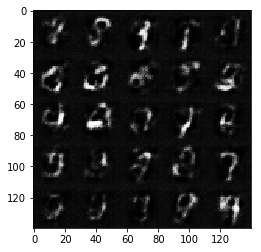

Epoch 1/2... Discriminator Loss: 0.6243... Generator Loss: 1.9803
Epoch 1/2... Discriminator Loss: 0.6371... Generator Loss: 2.1990
Epoch 1/2... Discriminator Loss: 0.6262... Generator Loss: 2.0952
Epoch 1/2... Discriminator Loss: 0.6195... Generator Loss: 2.6738
Epoch 1/2... Discriminator Loss: 1.0546... Generator Loss: 3.4523
Epoch 1/2... Discriminator Loss: 0.9617... Generator Loss: 2.6651
Epoch 2/2... Discriminator Loss: 0.6600... Generator Loss: 1.7310
Epoch 2/2... Discriminator Loss: 0.6154... Generator Loss: 2.2055
Epoch 2/2... Discriminator Loss: 0.6689... Generator Loss: 2.4230
Epoch 2/2... Discriminator Loss: 0.6541... Generator Loss: 2.3174


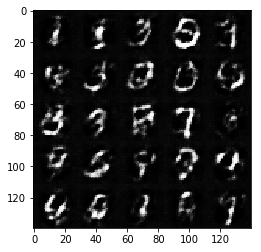

Epoch 2/2... Discriminator Loss: 0.5968... Generator Loss: 2.1728
Epoch 2/2... Discriminator Loss: 0.8773... Generator Loss: 2.9579
Epoch 2/2... Discriminator Loss: 0.6923... Generator Loss: 2.2918
Epoch 2/2... Discriminator Loss: 0.6747... Generator Loss: 2.3021
Epoch 2/2... Discriminator Loss: 1.2103... Generator Loss: 3.6821
Epoch 2/2... Discriminator Loss: 0.6710... Generator Loss: 1.8682
Epoch 2/2... Discriminator Loss: 0.7008... Generator Loss: 1.7104
Epoch 2/2... Discriminator Loss: 0.7057... Generator Loss: 2.0482
Epoch 2/2... Discriminator Loss: 0.7302... Generator Loss: 2.2920
Epoch 2/2... Discriminator Loss: 0.7769... Generator Loss: 1.1636


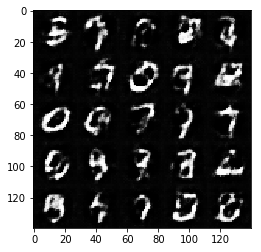

Epoch 2/2... Discriminator Loss: 0.7435... Generator Loss: 2.7191
Epoch 2/2... Discriminator Loss: 0.8815... Generator Loss: 2.4903
Epoch 2/2... Discriminator Loss: 0.6754... Generator Loss: 1.9600
Epoch 2/2... Discriminator Loss: 0.7527... Generator Loss: 2.4471
Epoch 2/2... Discriminator Loss: 0.8084... Generator Loss: 2.4551
Epoch 2/2... Discriminator Loss: 1.8583... Generator Loss: 4.2247
Epoch 2/2... Discriminator Loss: 0.8107... Generator Loss: 1.9687
Epoch 2/2... Discriminator Loss: 0.6935... Generator Loss: 1.6166
Epoch 2/2... Discriminator Loss: 0.7249... Generator Loss: 1.8079
Epoch 2/2... Discriminator Loss: 0.7510... Generator Loss: 2.2578


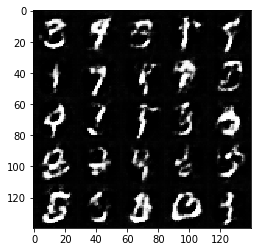

Epoch 2/2... Discriminator Loss: 0.7937... Generator Loss: 2.2062
Epoch 2/2... Discriminator Loss: 0.7542... Generator Loss: 1.8455
Epoch 2/2... Discriminator Loss: 0.9006... Generator Loss: 2.4015
Epoch 2/2... Discriminator Loss: 0.8822... Generator Loss: 2.1862
Epoch 2/2... Discriminator Loss: 0.7400... Generator Loss: 1.8670
Epoch 2/2... Discriminator Loss: 0.6954... Generator Loss: 2.0825
Epoch 2/2... Discriminator Loss: 0.7039... Generator Loss: 1.6458
Epoch 2/2... Discriminator Loss: 0.8521... Generator Loss: 0.9936
Epoch 2/2... Discriminator Loss: 1.3777... Generator Loss: 0.5111
Epoch 2/2... Discriminator Loss: 1.1871... Generator Loss: 0.6407


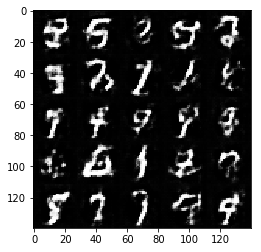

Epoch 2/2... Discriminator Loss: 0.8090... Generator Loss: 1.1337
Epoch 2/2... Discriminator Loss: 0.7691... Generator Loss: 1.2855
Epoch 2/2... Discriminator Loss: 0.7347... Generator Loss: 1.5057
Epoch 2/2... Discriminator Loss: 0.8913... Generator Loss: 0.9371
Epoch 2/2... Discriminator Loss: 1.4541... Generator Loss: 0.4794
Epoch 2/2... Discriminator Loss: 0.8272... Generator Loss: 1.1274
Epoch 2/2... Discriminator Loss: 0.8242... Generator Loss: 1.0623
Epoch 2/2... Discriminator Loss: 0.7517... Generator Loss: 1.2570
Epoch 2/2... Discriminator Loss: 0.7990... Generator Loss: 1.1335
Epoch 2/2... Discriminator Loss: 1.4550... Generator Loss: 0.4792


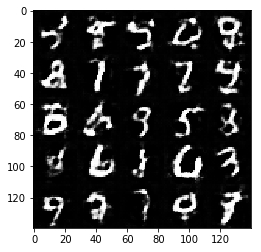

Epoch 2/2... Discriminator Loss: 0.9291... Generator Loss: 0.9104
Epoch 2/2... Discriminator Loss: 0.8697... Generator Loss: 1.0132
Epoch 2/2... Discriminator Loss: 1.0010... Generator Loss: 0.7829


In [52]:
batch_size = 128
z_dim = 100
learning_rate = 0.0001
beta1 = 0.1

tf.reset_default_graph()

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))

with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 1.0097... Generator Loss: 0.8950
Epoch 1/1... Discriminator Loss: 0.6247... Generator Loss: 2.1597
Epoch 1/1... Discriminator Loss: 0.5145... Generator Loss: 3.7364
Epoch 1/1... Discriminator Loss: 1.6013... Generator Loss: 0.5484
Epoch 1/1... Discriminator Loss: 1.6672... Generator Loss: 9.0165
Epoch 1/1... Discriminator Loss: 0.5985... Generator Loss: 2.3200
Epoch 1/1... Discriminator Loss: 0.7517... Generator Loss: 4.9827
Epoch 1/1... Discriminator Loss: 0.6771... Generator Loss: 1.6494
Epoch 1/1... Discriminator Loss: 1.4744... Generator Loss: 0.6654
Epoch 1/1... Discriminator Loss: 1.5294... Generator Loss: 0.4735


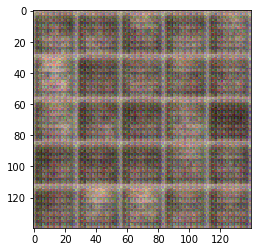

Epoch 1/1... Discriminator Loss: 1.3348... Generator Loss: 0.5744
Epoch 1/1... Discriminator Loss: 1.2460... Generator Loss: 0.6451
Epoch 1/1... Discriminator Loss: 1.0166... Generator Loss: 0.8994
Epoch 1/1... Discriminator Loss: 1.0508... Generator Loss: 0.8715
Epoch 1/1... Discriminator Loss: 0.8453... Generator Loss: 1.1914
Epoch 1/1... Discriminator Loss: 0.8102... Generator Loss: 1.4792
Epoch 1/1... Discriminator Loss: 1.1121... Generator Loss: 2.7969
Epoch 1/1... Discriminator Loss: 0.8430... Generator Loss: 1.7989
Epoch 1/1... Discriminator Loss: 0.8432... Generator Loss: 2.5185
Epoch 1/1... Discriminator Loss: 1.1432... Generator Loss: 2.8130


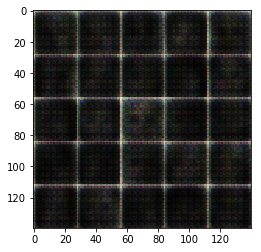

Epoch 1/1... Discriminator Loss: 1.0332... Generator Loss: 2.2804
Epoch 1/1... Discriminator Loss: 1.2788... Generator Loss: 3.0520
Epoch 1/1... Discriminator Loss: 0.9518... Generator Loss: 2.2991
Epoch 1/1... Discriminator Loss: 0.9984... Generator Loss: 2.9646
Epoch 1/1... Discriminator Loss: 1.0169... Generator Loss: 2.6334
Epoch 1/1... Discriminator Loss: 1.3404... Generator Loss: 2.4348
Epoch 1/1... Discriminator Loss: 1.5052... Generator Loss: 2.4552
Epoch 1/1... Discriminator Loss: 1.1943... Generator Loss: 1.9644
Epoch 1/1... Discriminator Loss: 1.3524... Generator Loss: 2.5283
Epoch 1/1... Discriminator Loss: 1.0188... Generator Loss: 1.8467


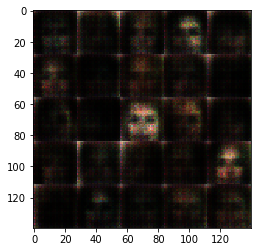

Epoch 1/1... Discriminator Loss: 0.9277... Generator Loss: 2.3631
Epoch 1/1... Discriminator Loss: 1.1190... Generator Loss: 2.1479
Epoch 1/1... Discriminator Loss: 0.8984... Generator Loss: 1.5875
Epoch 1/1... Discriminator Loss: 1.3461... Generator Loss: 2.1543
Epoch 1/1... Discriminator Loss: 0.9313... Generator Loss: 1.5928
Epoch 1/1... Discriminator Loss: 0.8853... Generator Loss: 2.0054
Epoch 1/1... Discriminator Loss: 1.1250... Generator Loss: 2.3498
Epoch 1/1... Discriminator Loss: 0.8573... Generator Loss: 1.7724
Epoch 1/1... Discriminator Loss: 0.8194... Generator Loss: 1.6335
Epoch 1/1... Discriminator Loss: 0.8192... Generator Loss: 1.8412


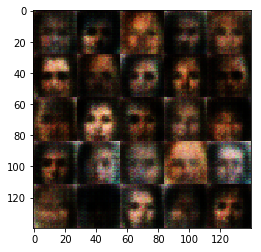

Epoch 1/1... Discriminator Loss: 1.3617... Generator Loss: 1.9336
Epoch 1/1... Discriminator Loss: 0.9223... Generator Loss: 1.4302
Epoch 1/1... Discriminator Loss: 0.8536... Generator Loss: 1.7300
Epoch 1/1... Discriminator Loss: 0.9865... Generator Loss: 1.9096
Epoch 1/1... Discriminator Loss: 1.0818... Generator Loss: 1.5900
Epoch 1/1... Discriminator Loss: 1.0868... Generator Loss: 1.5479
Epoch 1/1... Discriminator Loss: 1.8170... Generator Loss: 2.7377
Epoch 1/1... Discriminator Loss: 1.3274... Generator Loss: 1.9145
Epoch 1/1... Discriminator Loss: 1.1163... Generator Loss: 1.9338
Epoch 1/1... Discriminator Loss: 1.2513... Generator Loss: 1.8230


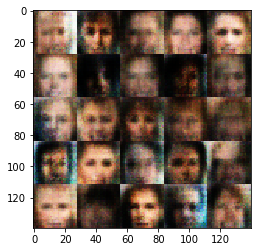

Epoch 1/1... Discriminator Loss: 0.8560... Generator Loss: 1.6031
Epoch 1/1... Discriminator Loss: 1.1839... Generator Loss: 1.6622
Epoch 1/1... Discriminator Loss: 1.3974... Generator Loss: 2.0294
Epoch 1/1... Discriminator Loss: 1.3182... Generator Loss: 1.7742
Epoch 1/1... Discriminator Loss: 0.9734... Generator Loss: 1.5056
Epoch 1/1... Discriminator Loss: 1.0147... Generator Loss: 1.3909
Epoch 1/1... Discriminator Loss: 1.0311... Generator Loss: 1.5799
Epoch 1/1... Discriminator Loss: 1.1523... Generator Loss: 1.9177
Epoch 1/1... Discriminator Loss: 1.2203... Generator Loss: 1.7553
Epoch 1/1... Discriminator Loss: 1.0944... Generator Loss: 1.6036


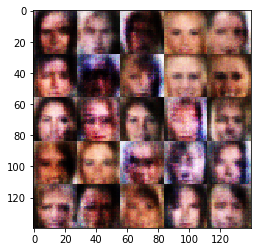

Epoch 1/1... Discriminator Loss: 1.6159... Generator Loss: 2.0889
Epoch 1/1... Discriminator Loss: 0.8880... Generator Loss: 1.4704
Epoch 1/1... Discriminator Loss: 1.3692... Generator Loss: 2.3746
Epoch 1/1... Discriminator Loss: 1.1290... Generator Loss: 1.1602
Epoch 1/1... Discriminator Loss: 1.1493... Generator Loss: 0.6672
Epoch 1/1... Discriminator Loss: 0.9536... Generator Loss: 1.0252
Epoch 1/1... Discriminator Loss: 1.2714... Generator Loss: 0.5651
Epoch 1/1... Discriminator Loss: 1.2204... Generator Loss: 0.5926
Epoch 1/1... Discriminator Loss: 1.1107... Generator Loss: 0.7431
Epoch 1/1... Discriminator Loss: 1.1971... Generator Loss: 0.6302


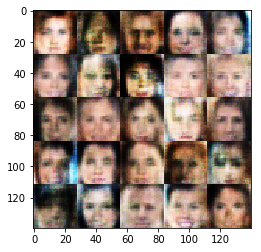

Epoch 1/1... Discriminator Loss: 1.3423... Generator Loss: 0.5180
Epoch 1/1... Discriminator Loss: 1.2136... Generator Loss: 0.6690
Epoch 1/1... Discriminator Loss: 1.2810... Generator Loss: 0.5382
Epoch 1/1... Discriminator Loss: 1.2782... Generator Loss: 0.5789
Epoch 1/1... Discriminator Loss: 1.4084... Generator Loss: 0.4662
Epoch 1/1... Discriminator Loss: 1.2509... Generator Loss: 0.5831
Epoch 1/1... Discriminator Loss: 1.1841... Generator Loss: 0.6555
Epoch 1/1... Discriminator Loss: 1.2616... Generator Loss: 0.5691
Epoch 1/1... Discriminator Loss: 1.2053... Generator Loss: 0.6247
Epoch 1/1... Discriminator Loss: 1.2225... Generator Loss: 0.5981


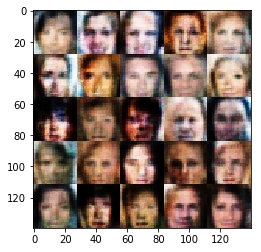

Epoch 1/1... Discriminator Loss: 1.8303... Generator Loss: 0.2937
Epoch 1/1... Discriminator Loss: 1.0165... Generator Loss: 0.8196
Epoch 1/1... Discriminator Loss: 1.1538... Generator Loss: 0.6851
Epoch 1/1... Discriminator Loss: 0.8668... Generator Loss: 1.0337
Epoch 1/1... Discriminator Loss: 1.0306... Generator Loss: 0.7814
Epoch 1/1... Discriminator Loss: 1.2676... Generator Loss: 0.5587
Epoch 1/1... Discriminator Loss: 0.8000... Generator Loss: 1.1878
Epoch 1/1... Discriminator Loss: 1.0506... Generator Loss: 0.7731
Epoch 1/1... Discriminator Loss: 1.1576... Generator Loss: 0.6520
Epoch 1/1... Discriminator Loss: 0.9666... Generator Loss: 0.8899


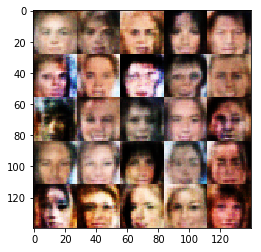

Epoch 1/1... Discriminator Loss: 1.2903... Generator Loss: 0.5518
Epoch 1/1... Discriminator Loss: 0.8136... Generator Loss: 1.1576
Epoch 1/1... Discriminator Loss: 0.9767... Generator Loss: 2.8490
Epoch 1/1... Discriminator Loss: 0.8273... Generator Loss: 2.5541
Epoch 1/1... Discriminator Loss: 0.5823... Generator Loss: 2.3648
Epoch 1/1... Discriminator Loss: 0.7797... Generator Loss: 3.6888
Epoch 1/1... Discriminator Loss: 0.6481... Generator Loss: 2.9274
Epoch 1/1... Discriminator Loss: 1.1084... Generator Loss: 3.2162
Epoch 1/1... Discriminator Loss: 0.8940... Generator Loss: 3.1697
Epoch 1/1... Discriminator Loss: 0.6897... Generator Loss: 3.2412


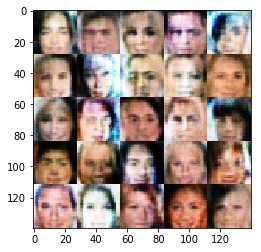

Epoch 1/1... Discriminator Loss: 0.6735... Generator Loss: 1.5866
Epoch 1/1... Discriminator Loss: 0.9515... Generator Loss: 0.8589
Epoch 1/1... Discriminator Loss: 0.9979... Generator Loss: 0.8153
Epoch 1/1... Discriminator Loss: 0.5857... Generator Loss: 1.8913
Epoch 1/1... Discriminator Loss: 0.5519... Generator Loss: 2.4205
Epoch 1/1... Discriminator Loss: 0.6372... Generator Loss: 2.6303
Epoch 1/1... Discriminator Loss: 1.5758... Generator Loss: 3.7023
Epoch 1/1... Discriminator Loss: 0.7443... Generator Loss: 3.0532
Epoch 1/1... Discriminator Loss: 0.4994... Generator Loss: 2.6587
Epoch 1/1... Discriminator Loss: 0.5363... Generator Loss: 3.3419


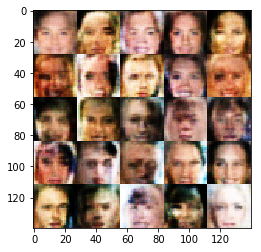

Epoch 1/1... Discriminator Loss: 1.0393... Generator Loss: 0.7496
Epoch 1/1... Discriminator Loss: 0.4583... Generator Loss: 3.2050
Epoch 1/1... Discriminator Loss: 0.5203... Generator Loss: 2.2146
Epoch 1/1... Discriminator Loss: 1.3741... Generator Loss: 0.5044
Epoch 1/1... Discriminator Loss: 0.8768... Generator Loss: 0.9723
Epoch 1/1... Discriminator Loss: 0.6068... Generator Loss: 1.6964
Epoch 1/1... Discriminator Loss: 1.0009... Generator Loss: 0.8103
Epoch 1/1... Discriminator Loss: 1.0360... Generator Loss: 0.7666
Epoch 1/1... Discriminator Loss: 0.6521... Generator Loss: 1.5108
Epoch 1/1... Discriminator Loss: 0.6793... Generator Loss: 4.2817


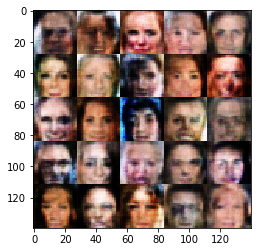

Epoch 1/1... Discriminator Loss: 0.6691... Generator Loss: 4.8245
Epoch 1/1... Discriminator Loss: 2.6087... Generator Loss: 2.7340
Epoch 1/1... Discriminator Loss: 0.6406... Generator Loss: 2.7148
Epoch 1/1... Discriminator Loss: 0.5021... Generator Loss: 3.4766
Epoch 1/1... Discriminator Loss: 0.7333... Generator Loss: 3.7712
Epoch 1/1... Discriminator Loss: 0.5134... Generator Loss: 3.4764
Epoch 1/1... Discriminator Loss: 0.4655... Generator Loss: 3.6663
Epoch 1/1... Discriminator Loss: 0.5380... Generator Loss: 3.9446
Epoch 1/1... Discriminator Loss: 1.2208... Generator Loss: 3.8406
Epoch 1/1... Discriminator Loss: 1.0181... Generator Loss: 3.1974


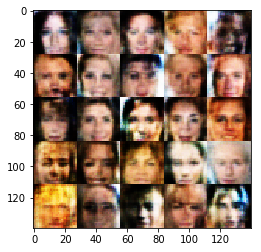

Epoch 1/1... Discriminator Loss: 0.4856... Generator Loss: 2.8155
Epoch 1/1... Discriminator Loss: 0.4648... Generator Loss: 3.0629
Epoch 1/1... Discriminator Loss: 0.6093... Generator Loss: 1.6753
Epoch 1/1... Discriminator Loss: 0.7682... Generator Loss: 1.1753
Epoch 1/1... Discriminator Loss: 0.4963... Generator Loss: 2.3454
Epoch 1/1... Discriminator Loss: 0.6951... Generator Loss: 1.3012
Epoch 1/1... Discriminator Loss: 0.6196... Generator Loss: 1.7030
Epoch 1/1... Discriminator Loss: 0.4607... Generator Loss: 2.7697
Epoch 1/1... Discriminator Loss: 0.5204... Generator Loss: 2.0606
Epoch 1/1... Discriminator Loss: 0.4189... Generator Loss: 3.4204


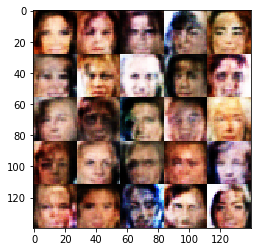

Epoch 1/1... Discriminator Loss: 0.4466... Generator Loss: 2.7802
Epoch 1/1... Discriminator Loss: 0.5532... Generator Loss: 1.8522
Epoch 1/1... Discriminator Loss: 0.4124... Generator Loss: 3.7555
Epoch 1/1... Discriminator Loss: 0.4634... Generator Loss: 3.3723
Epoch 1/1... Discriminator Loss: 0.5684... Generator Loss: 4.3942
Epoch 1/1... Discriminator Loss: 2.0558... Generator Loss: 0.2470
Epoch 1/1... Discriminator Loss: 0.6878... Generator Loss: 1.3907
Epoch 1/1... Discriminator Loss: 0.5706... Generator Loss: 1.8212
Epoch 1/1... Discriminator Loss: 0.4931... Generator Loss: 2.2595
Epoch 1/1... Discriminator Loss: 0.4552... Generator Loss: 3.0610


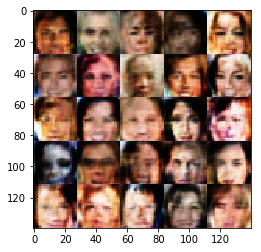

Epoch 1/1... Discriminator Loss: 0.5361... Generator Loss: 1.9638
Epoch 1/1... Discriminator Loss: 1.8734... Generator Loss: 0.2965
Epoch 1/1... Discriminator Loss: 0.5769... Generator Loss: 1.9133
Epoch 1/1... Discriminator Loss: 0.4363... Generator Loss: 3.1521
Epoch 1/1... Discriminator Loss: 0.4399... Generator Loss: 3.2003
Epoch 1/1... Discriminator Loss: 0.4154... Generator Loss: 3.2372
Epoch 1/1... Discriminator Loss: 0.4715... Generator Loss: 2.8162
Epoch 1/1... Discriminator Loss: 0.4337... Generator Loss: 4.1348


In [53]:
batch_size = 128
z_dim = 100
learning_rate = 0.0001
beta1 = 0.1

tf.reset_default_graph()

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.